In [4]:
# Simple training of multi-fidelity MEGNet bandgap model for materials project (version:mp.2019.4.1.json)
import gzip
import json
from typing import List

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import math

# Import megnet related modules
from pymatgen.core import Structure
from matgl.ext.pymatgen import get_element_list, Structure2Graph
from matgl.layers._bond import BondExpansion
from torch.optim.lr_scheduler import CosineAnnealingLR
from matgl.graph.data import MEGNetDataset, _collate_fn, MGLDataLoader
from matgl.models import MEGNet
#from matgl.utils.training import ModelTrainer
from sklearn.model_selection import train_test_split


os.chdir('/blue/hennig/ericfonseca/M2QM/TMQM/workspace/notebooks')

In [5]:
cif_path = './sco/cif'
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read
def get_struc(cif_path):
    try:
        struc_ase = read(cif_path)
        struc = AseAtomsAdaptor.get_structure(struc_ase)
    except:
        print(cif_path)
        struc = None
    return struc
cif_paths = [os.path.abspath(os.path.join(cif_path,i)) for i in os.listdir(cif_path) if i.endswith('.cif')]
import dask
strucs = dask.compute([dask.delayed(get_struc)(i) for i in cif_paths])[0]
len(strucs)


/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/ase/io/cif.py:401: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(2, setting=1). This may result in wrong setting!
  warnings.warn(
/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 0 and 30 are equivalent
  warnings.warn('scaled_positions %d and %d '
/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 1 and 31 are equivalent
  warnings.warn('scaled_positions %d and %d '
/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 2 and 32 are equivalent
  warnings.warn('scaled_positions %d and %d '
/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/ase/spacegroup/spacegroup.py:433: UserWarning: scaled_positions 3 and 33 are equivalent
  warnings.warn('sc

1601

In [6]:
elem_list = get_element_list(strucs)
elem_list


('H',
 'Li',
 'B',
 'C',
 'N',
 'O',
 'F',
 'Na',
 'Mg',
 'Al',
 'Si',
 'P',
 'S',
 'Cl',
 'K',
 'Ti',
 'V',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Ni',
 'Zn',
 'Ga',
 'Ge',
 'As',
 'Se',
 'Br',
 'Mo',
 'Rh',
 'Cd',
 'In',
 'Sn',
 'Sb',
 'Te',
 'I',
 'Dy',
 'W',
 'Re',
 'Au',
 'Hg',
 'Bi')

In [7]:
cry_graph = Structure2Graph(element_types=elem_list, cutoff=5.0)
cry_graph

In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv('./sco/data.csv')
targets = df['SpinCrossoverEnergy'].values
cif_df = pd.DataFrame()
cif_df['ID'] = [i.split('/')[-1].split('.')[0] for i in cif_paths]
df

,ID,SpinCrossoverEnergy,HomoLumoGap,IsSpinCrossover,TransitionMetal
0,ABILUT,-1.2004,3.3529,False,Cr
1,ALETAN,-1.4628,1.8257,False,Cr
2,ALUVIN,1.9084,1.6213,False,Cr
3,BAVGIO,1.9697,2.0845,False,Cr
4,BAVGOU,-0.5720,2.7672,False,Cr
...,...,...,...,...,...
1596,YIWPOM,0.7061,1.8973,False,Co
1597,YOWZER,-0.8128,1.8742,False,Co
1598,YUZKEK,-0.1803,1.5444,True,Co
1599,ZTDXCO,1.5416,1.8982,False,Co


In [9]:

df = pd.merge(cif_df, df, on='ID')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# setup the weight initialization using Xavier scheme
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            if param.dim() < 2:
                bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[0])
                param.data.uniform_(-bound, bound)
            else:
                bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
                param.data.uniform_(-bound, bound)

def get_data(df):
    ids = df['ID'].tolist()
    targets = df['SpinCrossoverEnergy'].values
    # convert the boolean in IsSpinCrossover to int
    attrs = df['IsSpinCrossover'].astype(int).values
    return ids, targets, attrs

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_ids, train_targets, train_attrs = get_data(train_df)
valid_ids, valid_targets, valid_attrs = get_data(valid_df)
test_ids, test_targets, test_attrs = get_data(test_df)
test_ids, test_targets, test_attrs

(['HIKZEH',
  'SAFGAJ',
  'IZOVEZ',
  'PEVXAP',
  'TICYOW',
  'FOKYEJ',
  'QOYGUG',
  'RATDUM',
  'TAPBUH',
  'ZUGTUQ',
  'LILZAI',
  'FIXGOJ',
  'KIJXIL01',
  'BIPZEF',
  'FAGNAD',
  'DUXGUA',
  'IQUGEG',
  'KEWBIX',
  'OBIBAE',
  'PECLUG',
  'BUXHOR',
  'OGUJOQ',
  'VIJTAK',
  'OVAZER',
  'OGUJIK',
  'JEGWIB',
  'RUFVIZ',
  'UKEDEU',
  'WIFSOT10',
  'LORBUQ',
  'UCARAU',
  'NODNOL',
  'MAMKIV',
  'GORDAU',
  'RAPXOY01',
  'ZTDXCO',
  'SOWZEJ',
  'CIPQAU',
  'CAFZEO',
  'SAPBUH',
  'CIMBUW',
  'RUKLOY',
  'MOHSIL',
  'ROCCUH',
  'PIMMOQ',
  'OPOMAJ',
  'WAZVOI',
  'FOGFIS',
  'WOJGIN',
  'BAVGIO',
  'QADGAG',
  'KEWYAO',
  'CARQUH01',
  'DUHMEZ',
  'DMAZCO03',
  'PRZCOB',
  'HOGBIQ',
  'UMEBUL',
  'OGIYIN',
  'XEPPAK',
  'SOPBII',
  'CUSBUN',
  'LUYVEG',
  'PAYPOU',
  'WOPVUS',
  'CITBIT',
  'QIXDIM',
  'COPKEY',
  'MANSOM',
  'BUBGIP',
  'AMIPAP',
  'FEYMIG',
  'NIJYOW',
  'IBUVUW',
  'YEJFUQ',
  'HEXRAD',
  'LUZJEV',
  'GIYXIW',
  'XEFPEF',
  'HEVKIF',
  'XAKJEA',
  'PUQVIG',
  'ENA

In [10]:
struc_df = pd.DataFrame()
struc_df['ID'] = [i.split('/')[-1].split('.')[0] for i in cif_paths]
# get the indexes that matches the train, valid, test split
train_idx = struc_df[struc_df['ID'].isin(train_ids)].index.tolist()
valid_idx = struc_df[struc_df['ID'].isin(valid_ids)].index.tolist()
test_idx = struc_df[struc_df['ID'].isin(test_ids)].index.tolist()

train_strucs = [strucs[i] for i in train_idx]
valid_strucs = [strucs[i] for i in valid_idx]
test_strucs = [strucs[i] for i in test_idx]
train_strucs[0]

Structure Summary
Lattice
    abc : 6.594 7.339 12.105
 angles : 89.69 89.12000000000002 75.01
 volume : 565.8000714913867
      A : 6.594 0.0 0.0
      B : 1.8982356914566025 7.089261051737359 0.0
      C : 0.18591214372480233 0.018021009916041473 12.103558853412382
    pbc : True True True
PeriodicSite: Cr (3.6616, 1.7673, 8.9781) [0.4632, 0.2474, 0.7418]
PeriodicSite: Cr (5.0165, 5.3400, 3.1255) [0.5368, 0.7526, 0.2582]
PeriodicSite: Cl (3.8103, 5.9459, 10.0919) [0.3135, 0.8366, 0.8338]
PeriodicSite: Cl (4.8679, 1.1614, 2.0116) [0.6865, 0.1634, 0.1662]
PeriodicSite: O (5.4564, 2.7021, 11.1776) [0.6924, 0.3788, 0.9235]
PeriodicSite: O (3.2217, 4.4052, 0.9259) [0.3076, 0.6212, 0.0765]
PeriodicSite: O (5.4833, 3.2121, 7.1048) [0.6850, 0.4516, 0.5870]
PeriodicSite: O (3.1949, 3.8952, 4.9988) [0.3150, 0.5484, 0.4130]
PeriodicSite: O (7.2554, 6.4202, 8.6807) [0.8199, 0.9038, 0.7172]
PeriodicSite: O (1.4228, 0.6871, 3.4229) [0.1801, 0.0962, 0.2828]
PeriodicSite: C (1.9350, 0.4714, 9.4819) 

In [11]:
# find the largest structure
largest_struc = max(strucs, key=lambda x: len(x))
num_atoms = 100

In [12]:
training_set = MEGNetDataset(
    train_strucs,
    train_targets,
    "SpinCrossoverEnergy",
    converter=cry_graph,
    initial=0.0,
    final=6.0,
    num_centers=num_atoms,
    width=0.5,
    #graph_labels=train_attrs,
)


  0%|                                                                                                   | 0/1024 [00:00<?, ?it/s]/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)
100%|████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:35<00:00, 29.00it/s]


In [13]:
validation_set = MEGNetDataset(
    valid_strucs,
    valid_targets,
    "SpinCrossoverEnergy",
    converter=cry_graph,
    initial=0.0,
    final=6.0,
    num_centers=num_atoms,
    width=0.5,
    #graph_labels=valid_attrs,
)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 33.16it/s]


In [14]:
test_set = MEGNetDataset(
    test_strucs,
    test_targets,
    "SpinCrossoverEnergy",
    converter=cry_graph,
    initial=0.0,
    final=6.0,
    num_centers=num_atoms,
    width=0.5,
    #graph_labels=test_attrs,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:10<00:00, 30.05it/s]


In [15]:
test_set[0]

(Graph(num_nodes=90, num_edges=4522,
       ndata_schemes={'attr': Scheme(shape=(42,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int64), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(shape=(3,), dtype=torch.float64), 'edge_attr': Scheme(shape=(100,), dtype=torch.float32)}),
 tensor(2.3937),
 tensor([0., 0.]))

In [16]:
training_set.save('sco_megset_train')
validation_set.save('sco_megset_valid')
test_set.save('sco_megset_test')

In [17]:
training_set[0][0]

Graph(num_nodes=50, num_edges=2246,
      ndata_schemes={'attr': Scheme(shape=(42,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int64), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(shape=(3,), dtype=torch.float64), 'edge_attr': Scheme(shape=(100,), dtype=torch.float32)})

In [18]:
EPOCHS = 101
# define the embedding layer for nodel and state attributes
n_embed_dim =  16
# state_embed_dim = 1
node_embed = nn.Embedding(len(elem_list), n_embed_dim)
# define the bond expansion
bond_expansion = BondExpansion(rbf_type="Gaussian", initial=0.0, final=6.0, num_centers=num_atoms, width=0.5)
#attr_embed = nn.Embedding(1, 16)

# define the achitecture of multi-fidelity MEGNet model
model = MEGNet(
    dim_node_embedding=n_embed_dim,
    dim_edge_embedding=num_atoms,
    nblocks=3,
    hidden_layer_sizes_input=(64, 32),
    hidden_layer_sizes_conv=(64, 64, 32),
    nlayers_set2set=1,
    niters_set2set=3,
    hidden_layer_sizes_output=(32, 16),
    is_classification=False,
    layer_node_embedding=node_embed,
   # layer_state_embedding=attr_embed,
    activation_type="softplus2",
    include_state_embedding=False,
    graph_converter=cry_graph,
    bond_expansion=bond_expansion,
    cutoff=5.0,
    gauss_width=0.5,
)



xavier_init(model)
# setup the optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-3, weight_decay=1.0e-2, amsgrad=True)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS * 10, eta_min=1.0e-4)
generator = torch.Generator(device="cpu")

# define the loss functions
train_loss_function = F.l1_loss
validate_loss_function = F.l1_loss
## using GraphDataLoader for batched graphs
train_loader, val_loader = MGLDataLoader(
    train_data=training_set,
    val_data=validation_set,
    collate_fn=_collate_fn,
    batch_size=128,
    num_workers=4,
    generator=generator,
)

/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
# setup the MEGNetTrainer
from matgl.utils.training import ModelTrainer
trainer = ModelTrainer(model=model, optimizer=optimizer, scheduler=scheduler)
# Train !
trainer.train(
    nepochs=EPOCHS,
    train_loss_func=train_loss_function,
    val_loss_func=validate_loss_function,
    train_loader=train_loader,
    val_loader=val_loader,
)

  0%|                                                                                                    | 0/101 [00:00<?, ?it/s]/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
  2%|█▊                                                                                       | 2/101 [05:10<4:15:46, 155.01s/it]


KeyboardInterrupt: 

<Axes: xlabel='epoch'>

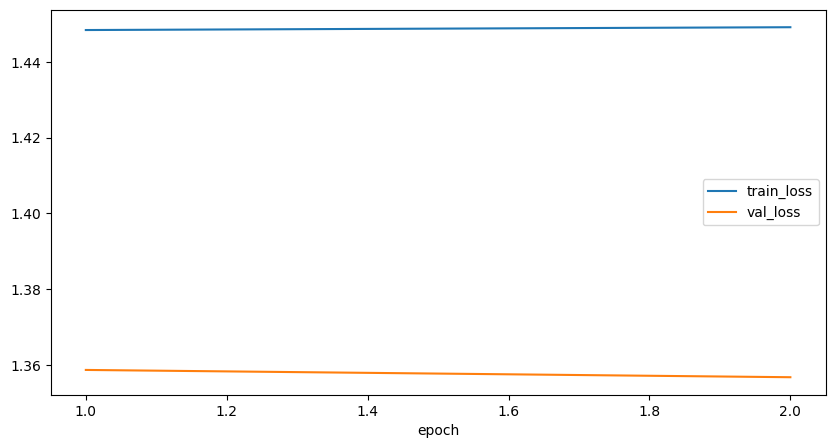

In [20]:
results = pd.read_csv('matgl_training/training_log.csv')
results.plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

/blue/hennig/ericfonseca/conda/meg/lib/python3.11/site-packages/dgl/readout.py:443: DGLWarning: For a single graph, use a tensor of shape (1, *) for graph_feat. The support of shape (*) will be deprecated.
  dgl_warning(


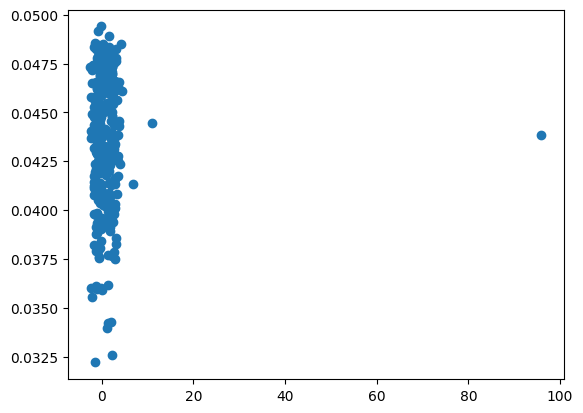

In [21]:
import matplotlib.pyplot as plt
model.predict_structure(test_strucs[10], graph_converter=cry_graph)
# predict all the test structures
pred = torch.tensor([])
plot_x = torch.tensor([])
for i in range(len(test_strucs)):
    pred = torch.cat((pred, model.predict_structure(test_strucs[i], graph_converter=cry_graph)))
    plot_x = torch.cat((plot_x, torch.from_numpy(np.array(test_targets[i])).reshape(1, -1)))
plt.scatter(plot_x, pred.detach().numpy())

# # plot the train predictions
# pred = torch.tensor([])
# plot_x = torch.tensor([])
# for i in range(len(train_strucs)):
#     pred = torch.cat((pred, model.predict_structure(train_strucs[i], graph_converter=cry_graph)))
#     plot_x = torch.cat((plot_x, torch.from_numpy(np.array(train_targets[i])).reshape(1, -1)))
# plt.scatter(plot_x, pred.detach().numpy())

In [29]:
def get_inputs(data):
    g = data[0]
    node_feat = g.ndata['node_type']
    edge_feat = g.edata['edge_attr']
    attrs = data[2]
    return g, node_feat, edge_feat, attrs
test_input = get_inputs(test_set[0])
print(test_input)
pred = model(test_input[0], test_input[0]['node_type'], test_input[0]['edge_attr'], test_input[3])
pred

(Graph(num_nodes=90, num_edges=4522,
      ndata_schemes={'attr': Scheme(shape=(42,), dtype=torch.float64), 'node_type': Scheme(shape=(), dtype=torch.int64), 'pos': Scheme(shape=(3,), dtype=torch.float64), 'volume': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'pbc_offset': Scheme(shape=(3,), dtype=torch.float64), 'lattice': Scheme(shape=(1, 3, 3), dtype=torch.float64), 'pbc_offshift': Scheme(shape=(3,), dtype=torch.float64), 'edge_attr': Scheme(shape=(100,), dtype=torch.float32)}), tensor([26, 26,  5,  5,  3,  3, 18, 18,  2,  2,  3,  3,  5,  5,  3,  3,  3,  3,
         0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  0,  0,  0,  0,  3,  3,  0,  0,
         0,  0,  0,  0,  3,  3,  0,  0,  3,  3,  0,  0,  3,  3,  0,  0,  3,  3,
         0,  0,  3,  3,  0,  0,  3,  3,  4,  4,  3,  3,  0,  0,  4,  4,  3,  3,
         0,  0,  3,  3,  0,  0,  0,  0,  0,  0,  3,  3,  0,  0,  0,  0,  0,  0]), tensor([[1.2667e-04, 1.6345e-04, 2.1014e-04,  ..., 2.5961e-01, 2.3458e-01,
         2.1119e-01]

DGLError: Invalid key "node_type". Must be one of the edge types.

In [30]:
model.forward??

Signature:
model.forward(
    graph: 'dgl.DGLGraph',
    edge_feat: 'torch.Tensor',
    node_feat: 'torch.Tensor',
    state_feat: 'torch.Tensor',
)
Source:   
    def forward(
        self,
        graph: dgl.DGLGraph,
        edge_feat: torch.Tensor,
        node_feat: torch.Tensor,
        state_feat: torch.Tensor,
    ):
        """
        Forward pass of MEGnet. Executes all blocks.

        :param graph: Input graph
        :param edge_feat: Edge features
        :param node_feat: Node features
        :param state_feat: State features.
        :return: Prediction
        """
        graph_transformations = self.graph_transformations
        edge_feat = self.edge_encoder(self.layer_edge_embedding(edge_feat))
        node_feat = self.node_encoder(self.layer_node_embedding(node_feat))
        if self.include_state_embedding:
            state_feat = self.state_encoder(self.layer_state_embedding(state_feat))
        else:
            state_feat = self.state_encoder(state_feat)

   

In [ ]:
gtest = torch.tensor([0])
bandgap = model.predict_structure(strucs[10], gtest)

IndexError: index out of range in self

In [ ]:
pred = torch.tensor([])
plot_y = torch.tensor([])
for i in range(len(test_strucs)):
    try:
        pred = torch.cat((pred,model.predict_structure(strucs[i]).unsqueeze(0)))
        plot_y = torch.cat((plot_y,torch.tensor([test_targets[i]])))
    except:
        print(i)
        continue
pred, plot_y

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(tensor([]), tensor([]))

(0.0, 1.0)

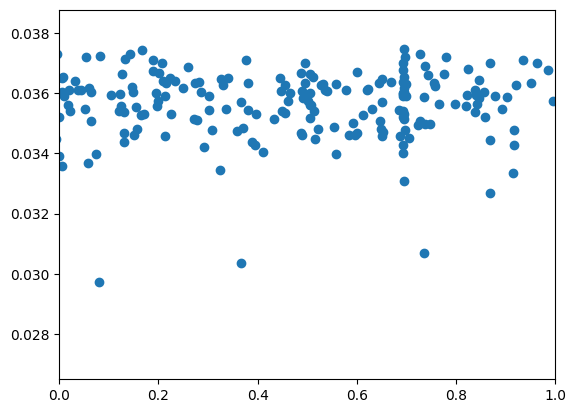

In [ ]:
plt.scatter(plot_y, pred)
plt.xlim([0, 1])